# Analysing Bidding Behaviour
---

## Slicing out unwanted columns
We will restrict our analysis to the segment 1 bids. For this purpose, it is suitable to use `master_data_wide.csv`as all undesirable columns can be sliced out.

In [1]:
#Importing the necessary packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import gaussian_kde
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

In [2]:
#Importing master_data_wide.csv from /data/processed; file directory is elsewhere

project_root = os.path.dirname(os.getcwd()) #Gets the project root: "..\ISO-Ne-Devasya"
path = os.path.join(project_root, "data", "processed", "master_data_wide.csv") #Stores the path "..\ISO-Ne-Devasya\data\processed\master_data_wide.csv"
data = pd.read_csv(path)

#Checking whether the data has been corretly imported into the notebook
data.head()     #Prints the first 5 rows of master_data_wide.csv, now saved as `data`

,Date,trade_int,lead_id,asset_id,must_take_eng,max_eng,eco_max,eco_min,cold_price,inter_price,...,seg10_mw,claim10,claim30,int_start,int_end,_ts,date,hour,market_type,source_file
0,2025-06-25,1,101197,11031,0,0.0,44.0,38.0,1226.23,1226.23,...,NaN,0.0,0.0,2025-06-25 00:00:00,2025-06-25 00:59:59.999,2025-06-25 00:00:00,2025-06-25,00:00:00,da,data_da_20250625_cleaned_no_neg.csv
1,2025-06-25,1,591975,12297,0,0.0,266.0,155.0,11809.83,8385.43,...,7.00,0.0,0.0,2025-06-25 00:00:00,2025-06-25 00:59:59.999,2025-06-25 00:00:00,2025-06-25,00:00:00,da,data_da_20250625_cleaned_no_neg.csv
2,2025-06-25,1,872788,17063,0,8880.0,326.3,179.5,21921.03,10542.31,...,0.05,0.0,0.0,2025-06-25 00:00:00,2025-06-25 00:59:59.999,2025-06-25 00:00:00,2025-06-25,00:00:00,da,data_da_20250625_cleaned_no_neg.csv
3,2025-06-25,1,412080,17698,0,0.0,36.0,36.0,3336.74,3336.74,...,NaN,0.0,30.1,2025-06-25 00:00:00,2025-06-25 00:59:59.999,2025-06-25 00:00:00,2025-06-25,00:00:00,da,data_da_20250625_cleaned_no_neg.csv
4,2025-06-25,1,101197,18898,0,0.0,46.0,38.0,1944.97,1944.97,...,NaN,0.0,0.0,2025-06-25 00:00:00,2025-06-25 00:59:59.999,2025-06-25 00:00:00,2025-06-25,00:00:00,da,data_da_20250625_cleaned_no_neg.csv


Since analysis on segment 1 bid is required, we need to slice out the data for other segments.

In [5]:
#Getting the column names
print(data.columns)

#Deriving the list of unwanted columns
unwanted_columns = [col for i in range(2, 11) for col in (f"seg{i}_price", f"seg{i}_mw")]
date_ts = ['date', '_ts']        #repeating columns; safe to omit
unwanted_columns = unwanted_columns + date_ts
print("Unwanted columns list:",unwanted_columns)

Index(['Date', 'trade_int', 'lead_id', 'asset_id', 'must_take_eng', 'max_eng',
       'eco_max', 'eco_min', 'cold_price', 'inter_price', 'hot_price',
       'no_load_price', 'seg1_price', 'seg1_mw', 'seg2_price', 'seg2_mw',
       'seg3_price', 'seg3_mw', 'seg4_price', 'seg4_mw', 'seg5_price',
       'seg5_mw', 'seg6_price', 'seg6_mw', 'seg7_price', 'seg7_mw',
       'seg8_price', 'seg8_mw', 'seg9_price', 'seg9_mw', 'seg10_price',
       'seg10_mw', 'claim10', 'claim30', 'int_start', 'int_end', '_ts', 'date',
       'hour', 'market_type', 'source_file'],
      dtype='object')
Unwanted columns list: ['seg2_price', 'seg2_mw', 'seg3_price', 'seg3_mw', 'seg4_price', 'seg4_mw', 'seg5_price', 'seg5_mw', 'seg6_price', 'seg6_mw', 'seg7_price', 'seg7_mw', 'seg8_price', 'seg8_mw', 'seg9_price', 'seg9_mw', 'seg10_price', 'seg10_mw', 'date', '_ts']


In [6]:
#Dropping the unwanted ones
data = data.drop(columns = unwanted_columns)
data.head(8)

,Date,trade_int,lead_id,asset_id,must_take_eng,max_eng,eco_max,eco_min,cold_price,inter_price,...,no_load_price,seg1_price,seg1_mw,claim10,claim30,int_start,int_end,hour,market_type,source_file
0,2025-06-25,1,101197,11031,0,0.0,44.0,38.0,1226.23,1226.23,...,594.33,67.04,43.0,0.0,0.0,2025-06-25 00:00:00,2025-06-25 00:59:59.999,00:00:00,da,data_da_20250625_cleaned_no_neg.csv
1,2025-06-25,1,591975,12297,0,0.0,266.0,155.0,11809.83,8385.43,...,3271.65,29.40,155.0,0.0,0.0,2025-06-25 00:00:00,2025-06-25 00:59:59.999,00:00:00,da,data_da_20250625_cleaned_no_neg.csv
2,2025-06-25,1,872788,17063,0,8880.0,326.3,179.5,21921.03,10542.31,...,1804.46,14.95,179.0,0.0,0.0,2025-06-25 00:00:00,2025-06-25 00:59:59.999,00:00:00,da,data_da_20250625_cleaned_no_neg.csv
3,2025-06-25,1,412080,17698,0,0.0,36.0,36.0,3336.74,3336.74,...,2414.77,180.93,35.0,0.0,30.1,2025-06-25 00:00:00,2025-06-25 00:59:59.999,00:00:00,da,data_da_20250625_cleaned_no_neg.csv
4,2025-06-25,1,101197,18898,0,0.0,46.0,38.0,1944.97,1944.97,...,594.33,100.75,43.0,0.0,0.0,2025-06-25 00:00:00,2025-06-25 00:59:59.999,00:00:00,da,data_da_20250625_cleaned_no_neg.csv
5,2025-06-25,1,101197,19426,0,0.0,42.0,38.0,1226.23,1226.23,...,594.33,67.04,41.0,0.0,0.0,2025-06-25 00:00:00,2025-06-25 00:59:59.999,00:00:00,da,data_da_20250625_cleaned_no_neg.csv
6,2025-06-25,1,591975,20846,0,0.0,243.0,184.0,36478.43,25450.07,...,6175.49,22.78,184.0,0.0,0.0,2025-06-25 00:00:00,2025-06-25 00:59:59.999,00:00:00,da,data_da_20250625_cleaned_no_neg.csv
7,2025-06-25,1,196063,22792,0,672.0,21.0,19.0,369.83,369.83,...,0.00,106.22,20.0,19.6,15.8,2025-06-25 00:00:00,2025-06-25 00:59:59.999,00:00:00,da,data_da_20250625_cleaned_no_neg.csv


In this context, using segment 1 price is helpful because it is the real one; all the assets for both the five days for both the markets have declared the price and the unit in the first segment. However, many of them did not go beyond the first one. So I had used extrapolation techniques to best predict the units and their prices in the subsequent segments.

Now that we have cleaned the data, we can proceed towards analysis.

## Average Price Time Series

A rudimentary summary of the bidding prices and the bidding units will form the base for further analysis.

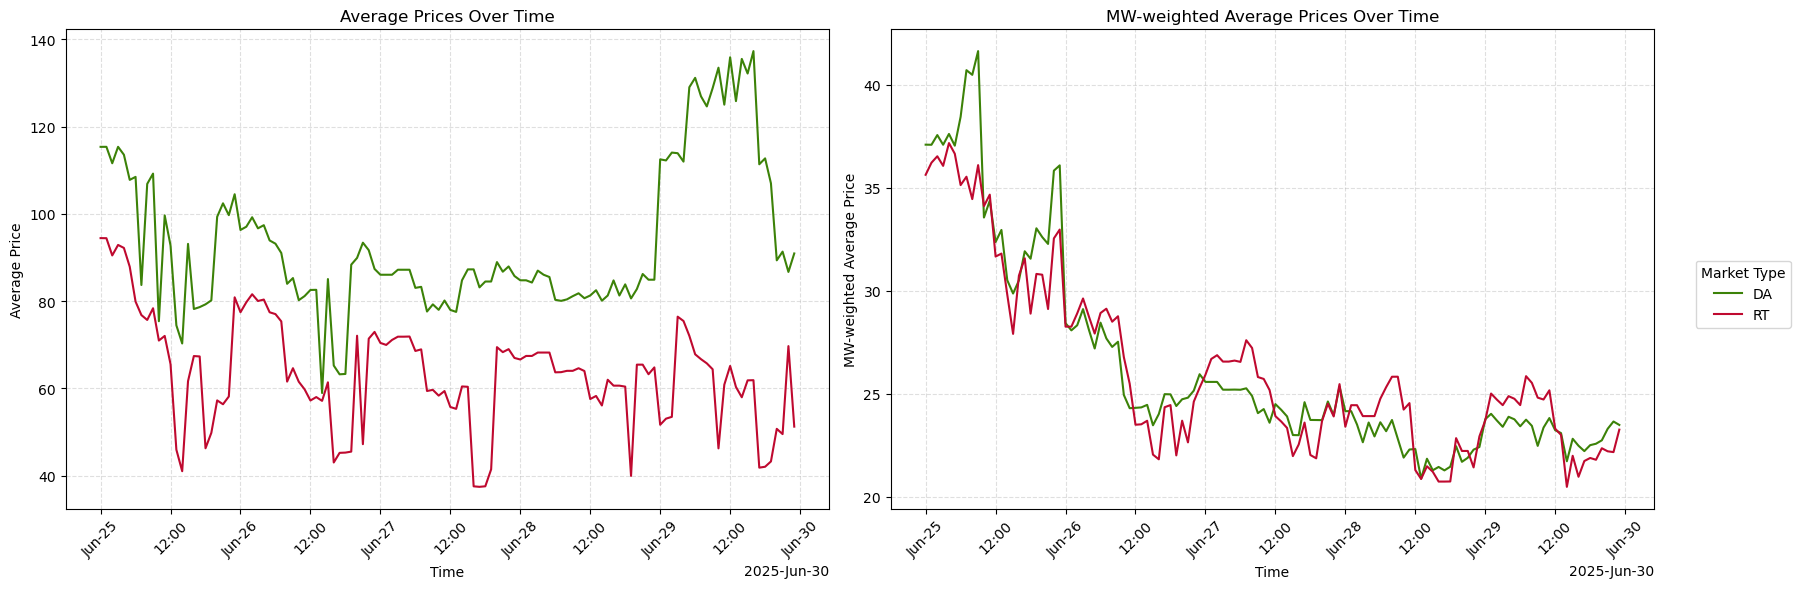

In [25]:
# Ensuring that the column 'int_start' is in datetime format
data["int_start"] = pd.to_datetime(data["int_start"])
data = data.sort_values("int_start")

# Computing simple average price per timestamp and market_type
avg_df = (
    data.groupby(["int_start", "market_type"], as_index=False)["seg1_price"]
        .mean()
)

# Computing MW-weighted average price per timestamp and market_type 
def weighted_price_calc(g):
    total_mw = g["seg1_mw"].sum()
    if total_mw == 0:
        return np.nan
    return (g["seg1_price"] * g["seg1_mw"]).sum() / total_mw

weighted_df = (
    data.groupby(["int_start", "market_type"], as_index=False)
        .apply(lambda g: pd.Series({"weighted_price": weighted_price_calc(g)}), include_groups=False)
)

# Pivoting both
avg_pivot = avg_df.pivot(index="int_start", columns="market_type", values="seg1_price").sort_index()
weighted_pivot = weighted_df.pivot(index="int_start", columns="market_type", values="weighted_price").sort_index()

# Defining function to set x-axis tick locators smartly
def format_time_axis(ax, pivot):
    span = pivot.index.max() - pivot.index.min()
    if span <= pd.Timedelta(days=2):
        locator = mdates.HourLocator(interval=1)
        fmt = mdates.DateFormatter("%b %d\n%H:%M")
    elif span <= pd.Timedelta(days=90):
        locator = mdates.AutoDateLocator(minticks=6, maxticks=12)
        fmt = mdates.ConciseDateFormatter(locator)
    else:
        locator = mdates.AutoDateLocator(minticks=6, maxticks=12)
        fmt = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(fmt)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.tick_params(axis='x', rotation=45)

# Plot side-by-side horizontally
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# Color palette
colors = {"da": "#3C8208", "rt": "#BF092F"}

# Left: simple average
ax = axes[0]
for col in avg_pivot.columns:
    ax.plot(avg_pivot.index, avg_pivot[col], label=col.upper(), color=colors[col], linewidth=1.5)
ax.set_xlabel("Time")
ax.set_ylabel("Average Price")
ax.set_title("Average Prices Over Time")
format_time_axis(ax, avg_pivot)

# Right: MW-weighted average
ax = axes[1]
for col in weighted_pivot.columns:
    ax.plot(weighted_pivot.index, weighted_pivot[col], label=col.upper(), color=colors[col], linewidth=1.5)
ax.set_xlabel("Time")
ax.set_ylabel("MW-weighted Average Price")
ax.set_title("MW-weighted Average Prices Over Time")
format_time_axis(ax, weighted_pivot)

# Shared legend (right side)
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title="Market Type", loc="center right")

# Adjust layout so legend fits nicely
plt.tight_layout(rect=[0, 0, 0.93, 1])
plt.show()

Two broad inferences can be made:

1. The simple average price line graph for both the markets do not show any significant seasonal trend as against the unit weighted avergae price line graph; and
2. Average price bids in the day-ahead market are higher than the real-time markets, although the same cannot be said for MW-weighed ones.

## Analysing negative price bids

In [7]:
#Summary statistics of seg1_mw and seg1_price
data[['seg1_price','seg1_mw']].describe()

,seg1_price,seg1_mw
count,10044.000000,10044.000000
mean,77.911973,105.387853
std,191.538485,195.471928
min,-150.000000,0.000000
25%,12.290000,11.000000
50%,27.650000,43.000000
75%,54.370000,150.000000
max,1000.000000,1235.000000


Why are there negative prices? Oversupply could be a reason.

In [30]:
#Getting the number of negative price bids by hour and market_type
neg_price_by_hour_market = (
    data[data["seg1_price"] < 0]
    .groupby(["asset_id", "market_type", "hour"])["seg1_price"]
    .count()
    .reset_index(name="neg_price_count")
)

#Checking
neg_price_by_hour_market

,asset_id,market_type,hour,neg_price_count
0,13275,da,00:00:00,4
1,13275,da,01:00:00,4
2,13275,da,02:00:00,4
3,13275,da,03:00:00,4
4,13275,da,04:00:00,4
...,...,...,...,...
245,88805,rt,11:00:00,4
246,88805,rt,12:00:00,3
247,88805,rt,13:00:00,4
248,88805,rt,14:00:00,3


In [34]:
# Select the key columns from neg_price_by_hour_market
keys = neg_price_by_hour_market[["asset_id", "market_type", "hour"]]

# Slice 'data' to include only rows with matching keys
negative_data_slice = data.merge(keys, on=["asset_id", "market_type", "hour"], how="inner")

# Check result
print(negative_data_slice.shape)
negative_data_slice.head()

(1065, 21)


,Date,trade_int,lead_id,asset_id,must_take_eng,max_eng,eco_max,eco_min,cold_price,inter_price,...,no_load_price,seg1_price,seg1_mw,claim10,claim30,int_start,int_end,hour,market_type,source_file
0,2025-06-25,1,206845,34748,0,1178.4,0.1,0.1,0.0,0.0,...,0.0,-150.0,0.0,0.0,0.0,2025-06-25,2025-06-25 00:59:59.999,00:00:00,rt,data_rt_20250625_cleaned_no_neg.csv
1,2025-06-25,1,399648,46072,3,0.0,15.5,3.0,0.0,0.0,...,0.0,-150.0,3.0,0.0,0.0,2025-06-25,2025-06-25 00:59:59.999,00:00:00,da,data_da_20250625_cleaned_no_neg.csv
2,2025-06-25,1,399648,77213,24,0.0,25.0,24.0,0.0,0.0,...,0.0,-150.0,13.0,0.0,0.0,2025-06-25,2025-06-25 00:59:59.999,00:00:00,da,data_da_20250625_cleaned_no_neg.csv
3,2025-06-25,1,399648,46072,3,0.0,15.5,3.0,0.0,0.0,...,0.0,-150.0,3.0,0.0,0.0,2025-06-25,2025-06-25 00:59:59.999,00:00:00,rt,data_rt_20250625_cleaned_no_neg.csv
4,2025-06-25,1,399648,77213,24,0.0,25.0,24.0,0.0,0.0,...,0.0,-150.0,13.0,0.0,0.0,2025-06-25,2025-06-25 00:59:59.999,00:00:00,rt,data_rt_20250625_cleaned_no_neg.csv


In [37]:
#Simple hourly average
time_series_avg = (
    negative_data_slice
    .groupby(["int_start", "market_type"])["seg1_price"]
    .mean()
    .reset_index()
)

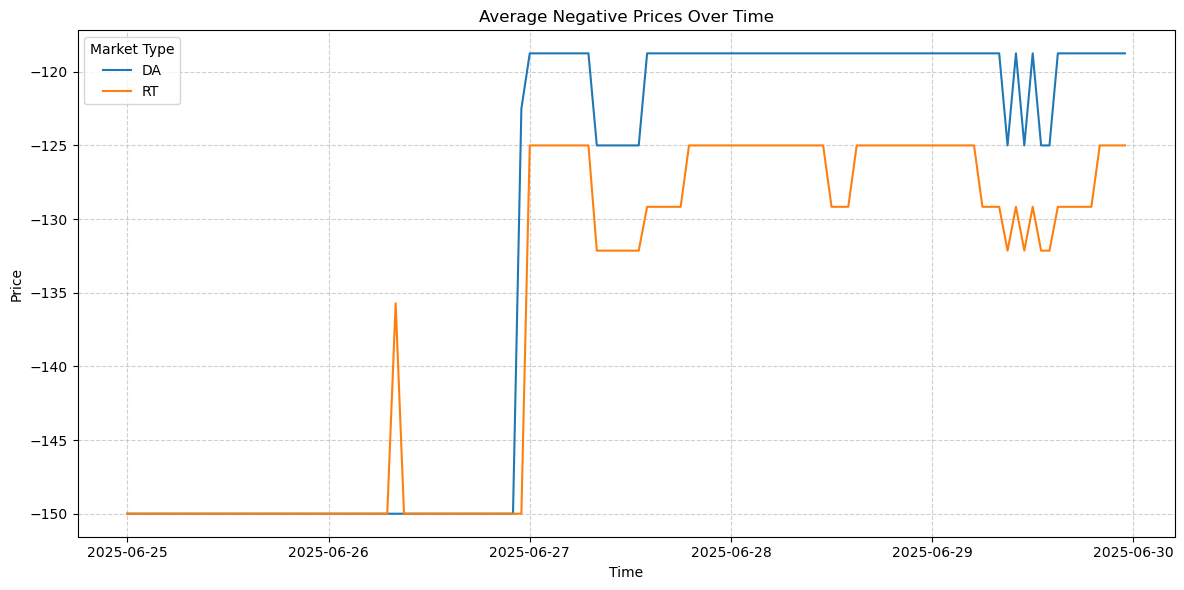

In [38]:
plt.figure(figsize=(12,6))

for market in time_series_avg["market_type"].unique():
    subset = time_series_avg[time_series_avg["market_type"] == market]
    plt.plot(subset["int_start"], subset["seg1_price"], label=market.upper())

plt.title("Average Negative Prices Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(title="Market Type")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

From this graph, we can see that the days-ahead prices are also at least higer than real-time markets. It is more interesting to know that these curves are parallele and have the same gradient (see the graph after 27 July). 

## Bid price distribution

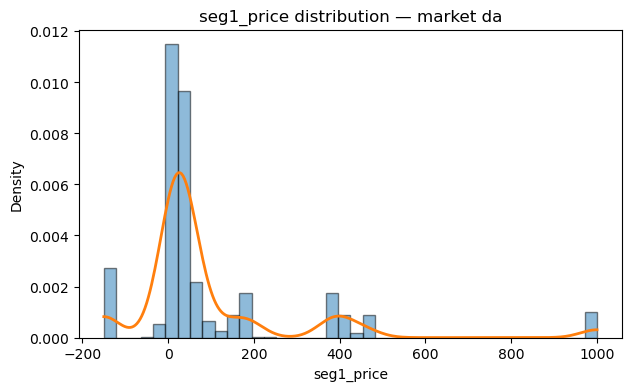

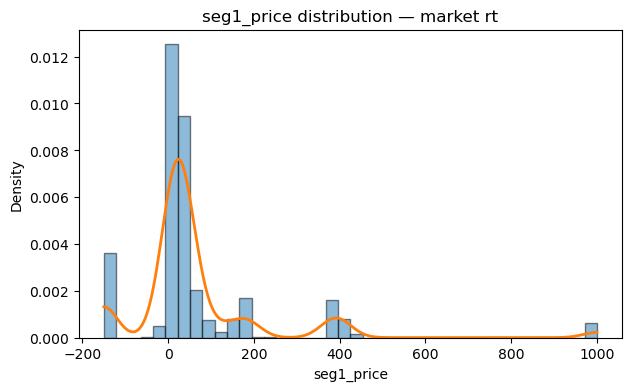

In [40]:
for market in data["market_type"].unique():
    s = data.loc[data["market_type"]==market, "seg1_price"].dropna()
    plt.figure(figsize=(7,4))
    plt.hist(s, bins=40, density=True, alpha=0.5, edgecolor="k")
    try:
        kde = gaussian_kde(s)
        xs = np.linspace(s.min(), s.max(), 300)
        plt.plot(xs, kde(xs), lw=2)
    except Exception:
        pass
    plt.title(f"seg1_price distribution — market {market}")
    plt.xlabel("seg1_price")
    plt.ylabel("Density")
    plt.show()

This is a right skewed distribution for both the markets.